In [33]:
%matplotlib inline

import os
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pathlib import Path


# Load simulation data 

base_dir = '/Users/susannedahle/CellTypeDependenceElStim/imem_plot_data' # Available uppon request

# Imem plot data for selected frequencies
imem_plot_file_paths = [
    os.path.join(base_dir, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [9]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [37]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)"
}

cell_colors = {
    'L4_BP_bIR215_5': "tab:pink",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown'
}


In [38]:
def plot_scatter_sum_imem_vs_z_white_noise_broken_x(imem_plot_file_paths, selected_cells=None,
                                                     xlim1=(0, 0.00025), xlim2=(0.002, None)):
    imem_amp_dict = load_plot_data_from_files(imem_plot_file_paths, selected_cells)
    
    unique_cells = list(imem_amp_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]

    num_cells = len(unique_cells)

    fig = plt.figure(figsize=(6, 3 * num_cells))
    plt.rcParams['mathtext.fontset'] = 'stix'
    gs = gridspec.GridSpec(num_cells, 3, figure=fig, width_ratios=[1, 1.2, 1.2], wspace=0.2, hspace=0.4)

    axs = {}

    for i, label in enumerate(unique_cells):
        axs[label] = {
            
            'morph': fig.add_subplot(gs[i, 0]),
            'imem_left': fig.add_subplot(gs[i, 1]),
            'imem_right': fig.add_subplot(gs[i, 2], sharey=fig.axes[-1] if i > 0 else None),
        }

    for label, ax_dict in axs.items():
        cell_data = imem_amp_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        z_coords = z.mean(axis=-1)

        # -- Morphology plot
        ax1 = ax_dict['morph']
        for idx in range(totnsegs):
            ax1.plot(x[idx], z[idx], c=cell_colors[label], lw=1)
        ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', label="Soma", markersize=2)
        ax1.set_title(f'{cell_names[label]}')
        ax1.set_xlabel('x [µm]')
        ax1.set_ylabel('z [µm]')
        ax1.set_aspect('equal')
        ax1.legend(loc='best', fontsize = 'x-small')

        if label == 'L4_BP_bIR215_5':
            ax1.set_xlim(np.min(x.mean(axis=-1) )- 150, np.max(x.mean(axis=-1))+150)
        elif label == "L5_MC_bAC217_1" or label == "L5_TTPC2_cADpyr232_3":
            ax1.set_xlim(np.min(x.mean(axis=-1) )- 50, np.max(x.mean(axis=-1))+50)

        # -- Imem scatter plots
        ax_left = ax_dict['imem_left']
        ax_right = ax_dict['imem_right']
        colors = ['tab:purple', 'tab:orange', 'tab:green']

        for f_idx, f in enumerate(freqs):
            z_imem_map = defaultdict(float)
            for seg_idx in range(totnsegs):
                z_imem_map[z_coords[seg_idx]] += imem_amps[seg_idx][f_idx]

            z_vals = list(z_imem_map.keys())
            imem_vals = list(z_imem_map.values())
            if f == 10:
                alpha = 0.8
                marker = 'o'
                markersize = 20
            elif f == 100:
                alpha = 0.8
                marker = 'x'
                markersize = 10
            else:
                alpha = 0.5
                marker = '^'
                markersize = 10
            ax_left.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=alpha, marker = marker, color = colors[f_idx], s = markersize)
            ax_right.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=0.7, marker = marker, color = colors[f_idx], s = markersize)

        # Set x-limits
        ax_left.set_xlim(xlim1)
        if xlim2[1] is None:
            xmax = max([max(v) for v in imem_amps.T])
            ax_right.set_xlim((xlim2[0], xmax+0.0001))
        else:
            ax_right.set_xlim(xlim2)

        # Hide spines between broken axes
        ax_left.spines['right'].set_visible(False)
        ax_right.spines['left'].set_visible(False)
        ax_left.yaxis.tick_left()
        ax_right.yaxis.tick_right()
        ax_right.yaxis.set_label_position('right')

        for ax in [ax_left, ax_right]:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
            ax.tick_params(axis='x', labelrotation=45)

        # Add break markers (diagonal slashes)
        d = .015  # size of diagonal lines
        kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
        ax_left.plot([1 - d, 1 + d], [-d, +d], **kwargs)
        ax_left.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

        kwargs.update(transform=ax_right.transAxes)
        ax_right.plot([-d, +d], [-d, +d], **kwargs)
        ax_right.plot([-d, +d], [1 - d, 1 + d], **kwargs)

        # Set shared labels and legends
        ax_right.set_ylabel('z [µm]')
        #ax_left.set_title('Imem amplitude vs z (broken x-axis)')
        ax_right.legend(loc='best')

    fig.text(0.62, 0.04, 'Sum of $I_\mathrm{m}$ amplitudes [nA]', ha='center', fontsize=10)
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Plots_artikkel/imem/Imem_scatter_neocortical.png')
    plt.show()


<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:112: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_46913/4180784266.py:112: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.62, 0.04, 'Sum of $I_\mathrm{m}$ amplitudes [nA]', ha='center', fontsize=10)


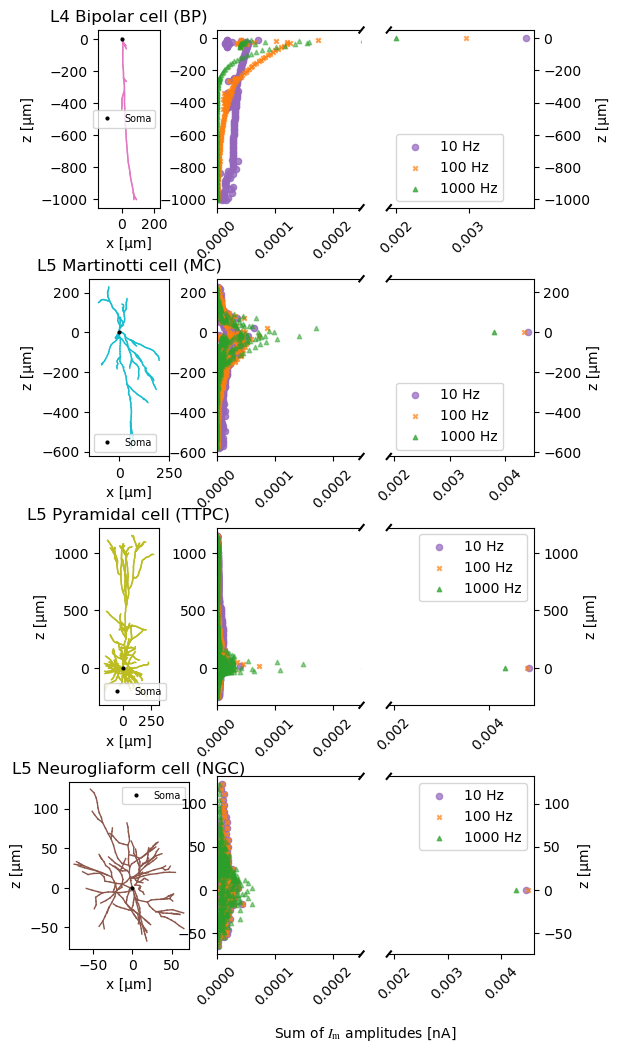

In [39]:
plot_scatter_sum_imem_vs_z_white_noise_broken_x(imem_plot_file_paths, selected_cells, xlim1=(0, 0.00025), xlim2=(0.0019, None))